# Reference Implementation

### Load train data and import libraries.

In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

NUMBER_OF_CLASSES=5


gabriel_features = np.genfromtxt('../data/processed/train_combined_features.csv', skip_header=True, dtype=float, delimiter=',')
y = tf.one_hot(indices=gabriel_features[:,0], depth=NUMBER_OF_CLASSES).numpy()
X = gabriel_features[:,1:]

X = X / X.max(axis=0) # alongside rows, per column

print(X.shape, y.shape)
number_of_features = X.shape[1]

np.random.seed(42)

2025-01-04 20:10:16.190395: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


(10000, 116) (10000, 5)


In [2]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=42)

### Helper functions

In [3]:


def softmax(v: np.ndarray):
    v_max = np.max(v, axis=1)[:, np.newaxis]
    exp = np.exp(v - v_max) 
    return exp / np.sum(exp, axis=1)[:, np.newaxis]


def cross_entropy(y: np.ndarray, a_o: np.ndarray):
    # numerical stability
    epsilon = 1e-12
    a_o = np.clip(a_o, epsilon, 1. - epsilon)
    return -np.mean(np.sum(y * np.log(a_o), axis=1))

def softmax_cross_entropy2deriv(y, output):
    """I'm comput dL/da * da/dz in one step in order to avoid tinkering with jacobi of softmax"""
    return (output-y)/len(y)
 
def relu(x):
    return (x>0)*x
def relu2deriv(output):
    return output > 0



In [4]:
hidden_size_1=128
hidden_size_2=128
hidden_size_3=128
output_size=5
alpha=0.1
beta=0.9

# using glorot and he initialization to omit symmetry problem
y_val_errs = []
y_train_errs = []
weights_0_1 = np.random.randn(X.shape[1], hidden_size_1) * np.sqrt(2 / X.shape[1])
weights_1_2 = np.random.randn(hidden_size_1, hidden_size_2) * np.sqrt(2 / hidden_size_1)
weights_2_3 = np.random.randn(hidden_size_2, hidden_size_3) * np.sqrt(2 / hidden_size_2)
weights_3_4 = np.random.randn(hidden_size_3, output_size) * np.sqrt(2 / (hidden_size_3+y.shape[1]))

# just constants
biases_1 = np.zeros((1, hidden_size_1))
biases_2 = np.zeros((1, hidden_size_2))
biases_3 = np.zeros((1, hidden_size_3))
biases_4 = np.zeros((1, y.shape[1]))


weights_0_1_velocity, weights_1_2_velocity, weights_2_3_velocity, weights_3_4_velocity = (0, 0, 0, 0)
biases_1_velocity, biases_2_velocity, biases_3_velocity, biases_4_velocity = (0, 0, 0, 0)
# better naming - like velocity and gradient_after_velocity


epochs = 100
batch_size = 32

### Momentum Implementation (ONLY FOR TESTING!)

In [ ]:
i=0
for epoch in range(epochs):
    perm = np.random.permutation(X_train.shape[0])
    X_train_shuffled = X_train[perm]
    y_train_shuffled = y_train[perm]

    b=0
    for batch_i in range(0, X_train.shape[0], batch_size):
        
        labels=y_train_shuffled[batch_i:batch_i+batch_size]
        layers_0 = X_train_shuffled[batch_i:batch_i+batch_size]
        
        idx = np.random.choice(X_train.shape[0], 32, replace=False)
        layers_1 = relu(layers_0 @ weights_0_1 + biases_1) 
        mask_1 = np.random.randint(2, size=layers_1.shape)
        # layers_1 *= mask_1 * 2
        layers_2 = relu(layers_1 @ weights_1_2 + biases_2)
        mask_2 = np.random.randint(2, size=layers_2.shape)
        # layers_2 *= mask_2 * 2
        layers_3 = relu(layers_2 @ weights_2_3 + biases_3)
        mask_3 = np.random.randint(2, size=layers_3.shape)
        # layers_3 *= mask_3 * 2
        layers_4 = softmax(layers_3 @ weights_3_4 + biases_4)
        
        # print(cross_entropy(labels, layers_4))
        
        layers_4_delta = softmax_cross_entropy2deriv(labels, layers_4) # we combine dL/dz * dz/a
        layers_3_delta = layers_4_delta @ weights_3_4.T * relu2deriv(layers_3)
        # layers_3_delta *= mask_3
        layers_2_delta = layers_3_delta @ weights_2_3.T * relu2deriv(layers_2)
        # layers_2_delta *= mask_2
        layers_1_delta = layers_2_delta @ weights_1_2.T * relu2deriv(layers_1) 
        # layers_1_delta *= mask_1
        
        # we can add and add them.

        
        weights_3_4_velocity = beta*weights_3_4_velocity+alpha*(layers_3.T @ layers_4_delta)
        weights_2_3_velocity = beta*weights_2_3_velocity+alpha*(layers_2.T @ layers_3_delta)
        weights_1_2_velocity = beta*weights_1_2_velocity+alpha*(layers_1.T @ layers_2_delta)
        weights_0_1_velocity = beta*weights_0_1_velocity+alpha*(layers_0.T @ layers_1_delta)

        biases_4_velocity = beta*biases_4_velocity+alpha*layers_4_delta.sum(axis=0)
        biases_3_velocity = beta*biases_3_velocity+alpha*layers_3_delta.sum(axis=0)
        biases_2_velocity = beta*biases_2_velocity+alpha*layers_2_delta.sum(axis=0)
        biases_1_velocity = beta*biases_1_velocity+alpha*layers_1_delta.sum(axis=0)
        
        weights_3_4 -= weights_3_4_velocity
        weights_2_3 -= weights_2_3_velocity
        weights_1_2 -= weights_1_2_velocity
        weights_0_1 -= weights_0_1_velocity

        biases_4 -= biases_4_velocity
        biases_3 -= biases_3_velocity
        biases_2 -= biases_2_velocity
        biases_1 -= biases_1_velocity

    def pred(inputs: np.ndarray) -> np.ndarray:
        layers_1 = relu(inputs @ weights_0_1 + biases_1) 
        layers_2 = relu(layers_1 @ weights_1_2 + biases_2)
        layers_3 = relu(layers_2 @ weights_2_3 + biases_3)
        layers_4 = softmax(layers_3 @ weights_3_4 + biases_4)
        return layers_4
    y_val_pred = pred(X_val)
    y_train_pred = pred(X_train)
    # THIS is the exact same way that Keras default AUC (which we use in reference) is computed!
    # if y_val or layers_4 contain Nans, print them!
    y_val_err = cross_entropy(y_val, y_val_pred)
    y_train_err = cross_entropy(y_train, y_train_pred)

    y_val_errs.append(y_val_err)
    y_train_errs.append(y_train_err)
    i+=1
    print(f'Epoch {i} - train error: {y_train_err}, val error: {y_val_err}')

### NAG (PROPER IMPLEMENTATION)

In [5]:
i=0
for epoch in range(epochs):
    perm = np.random.permutation(X_train.shape[0])
    X_train_shuffled = X_train[perm]
    y_train_shuffled = y_train[perm]

    b=0
    for batch_i in range(0, X_train.shape[0], batch_size):
        
        labels=y_train_shuffled[batch_i:batch_i+batch_size]
        layers_0 = X_train_shuffled[batch_i:batch_i+batch_size]
        
        velocity_factor_weights_3_4 = beta*weights_3_4_velocity
        velocity_factor_weights_2_3 = beta*weights_2_3_velocity
        velocity_factor_weights_1_2 = beta*weights_1_2_velocity
        velocity_factor_weights_0_1 = beta*weights_0_1_velocity

        velocity_factor_biases_4 = beta*biases_4_velocity
        velocity_factor_biases_3 = beta*biases_3_velocity
        velocity_factor_biases_2 = beta*biases_2_velocity
        velocity_factor_biases_1 = beta*biases_1_velocity

        weights_3_4 -= velocity_factor_weights_3_4
        weights_2_3 -= velocity_factor_weights_2_3
        weights_1_2 -= velocity_factor_weights_1_2
        weights_0_1 -= velocity_factor_weights_0_1
        
        biases_4 -= velocity_factor_biases_4
        biases_3 -= velocity_factor_biases_3
        biases_2 -= velocity_factor_biases_2
        biases_1 -= velocity_factor_biases_1

        layers_1 = relu(layers_0 @ weights_0_1 + biases_1) 
        mask_1 = np.random.randint(2, size=layers_1.shape)
        layers_1 *= mask_1 * 2
        layers_2 = relu(layers_1 @ weights_1_2 + biases_2)
        mask_2 = np.random.randint(2, size=layers_2.shape)
        layers_2 *= mask_2 * 2
        layers_3 = relu(layers_2 @ weights_2_3 + biases_3)
        mask_3 = np.random.randint(2, size=layers_3.shape)
        layers_3 *= mask_3 * 2
        layers_4 = softmax(layers_3 @ weights_3_4 + biases_4)
        
        # print(cross_entropy(labels, layers_4))
        
        layers_4_delta = softmax_cross_entropy2deriv(labels, layers_4) # we combine dL/dz * dz/a
        layers_3_delta = layers_4_delta @ weights_3_4.T * relu2deriv(layers_3)
        layers_3_delta *= mask_3
        layers_2_delta = layers_3_delta @ weights_2_3.T * relu2deriv(layers_2)
        layers_2_delta *= mask_2
        layers_1_delta = layers_2_delta @ weights_1_2.T * relu2deriv(layers_1) 
        layers_1_delta *= mask_1

        # we can add and add them.

        correction_factor_weights_3_4 = alpha*(layers_3.T @ layers_4_delta)
        correction_factor_weights_2_3 = alpha*(layers_2.T @ layers_3_delta)
        correction_factor_weights_1_2 = alpha*(layers_1.T @ layers_2_delta)
        correction_factor_weights_0_1 = alpha*(layers_0.T @ layers_1_delta)
        
        correction_factor_biases_4 = alpha*layers_4_delta.sum(axis=0)
        correction_factor_biases_3 = alpha*layers_3_delta.sum(axis=0)
        correction_factor_biases_2 = alpha*layers_2_delta.sum(axis=0)
        correction_factor_biases_1 = alpha*layers_1_delta.sum(axis=0)

        weights_3_4 -= correction_factor_weights_3_4
        weights_2_3 -= correction_factor_weights_2_3
        weights_1_2 -= correction_factor_weights_1_2
        weights_0_1 -= correction_factor_weights_0_1
        
        biases_4 -= correction_factor_biases_4
        biases_3 -= correction_factor_biases_3
        biases_2 -= correction_factor_biases_2
        biases_1 -= correction_factor_biases_1
        
        weights_3_4_velocity = velocity_factor_weights_3_4 + correction_factor_weights_3_4
        weights_2_3_velocity = velocity_factor_weights_2_3 + correction_factor_weights_2_3
        weights_1_2_velocity = velocity_factor_weights_1_2 + correction_factor_weights_1_2
        weights_0_1_velocity = velocity_factor_weights_0_1 + correction_factor_weights_0_1
        
        biases_4_velocity = velocity_factor_biases_4 + correction_factor_biases_4
        biases_3_velocity = velocity_factor_biases_3 + correction_factor_biases_3
        biases_2_velocity = velocity_factor_biases_2 + correction_factor_biases_2
        biases_1_velocity = velocity_factor_biases_1 + correction_factor_biases_1
        print('-'*int(b/250*100), end='\r')
        b+=1
    print()    

    def pred(inputs: np.ndarray) -> np.ndarray:
        layers_1 = relu(inputs @ weights_0_1 + biases_1) 
        layers_2 = relu(layers_1 @ weights_1_2 + biases_2)
        layers_3 = relu(layers_2 @ weights_2_3 + biases_3)
        layers_4 = softmax(layers_3 @ weights_3_4 + biases_4)
        return layers_4
    y_val_pred = pred(X_val)
    y_train_pred = pred(X_train)
    # THIS is the exact same way that Keras default AUC (which we use in reference) is computed!
    # if y_val or layers_4 contain Nans, print them!
    y_val_err = cross_entropy(y_val, y_val_pred)
    y_train_err = cross_entropy(y_train, y_train_pred)

    y_val_errs.append(y_val_err)
    y_train_errs.append(y_train_err)
    
    i+=1
    print(f'Epoch {i} - train error: {y_train_err}, val error: {y_val_err}')

---------------------------------------------------------------------------------------------------
Epoch 1 - train error: 0.9285989896621574, val error: 0.9355399512254782
---------------------------------------------------------------------------------------------------
Epoch 2 - train error: 0.7067475696555753, val error: 0.7181425358079075
---------------------------------------------------------------------------------------------------
Epoch 3 - train error: 0.6564112537667662, val error: 0.6710762913657207
---------------------------------------------------------------------------------------------------
Epoch 4 - train error: 0.7009395722567702, val error: 0.7216164538465344
---------------------------------------------------------------------------------------------------
Epoch 5 - train error: 0.7572636555858397, val error: 0.7674831692214694
---------------------------------------------------------------------------------------------------
Epoch 6 - train error: 0.7304057979

### NAG Eval

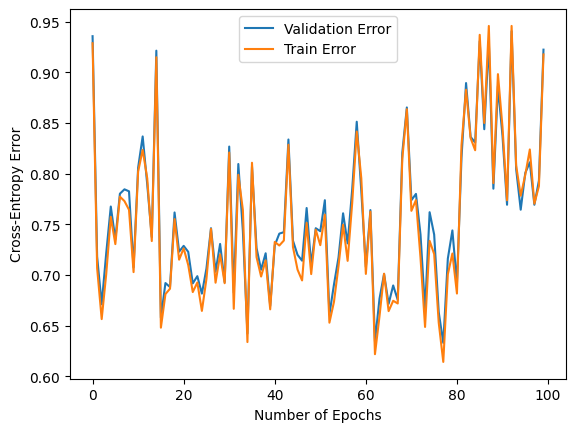

In [6]:
plt.figure()
plt.plot(y_val_errs, label='Validation Error')
plt.plot(y_train_errs, label='Train Error')
plt.xlabel('Number of Epochs')
plt.ylabel('Cross-Entropy Error')
plt.legend()
plt.show()

In [7]:

gabriel_features = np.genfromtxt('../data/processed/test_combined_features.csv', skip_header=True, dtype=float, delimiter=',')
y = tf.one_hot(indices=gabriel_features[:,0], depth=NUMBER_OF_CLASSES).numpy()
X = gabriel_features[:,1:]

X = X / X.max(axis=0) # alongside rows, per column

print(X.shape, y.shape)
number_of_features = X.shape[1]



(5000, 116) (5000, 5)


Test evaluation

In [8]:
y_test_pred = pred(X)
y_test = y

print(roc_auc_score(y_test, y_test_pred, multi_class='ovr', average='macro'))
print(accuracy_score(y_test.argmax(axis=1), y_test_pred.argmax(axis=1)))


0.8609184000000001
0.4676
